In [3]:
import numpy as np
import pandas as pd
import xarray as xr

## ESRI data

The most recent 2020 census tracts are used to aggregate the data. More info about each netCDF is below:
 
- Daily Minimum temperature from 2006-2021  
- Daily Maximum temperature from 2006-2021
- Daily Relative Humidity from 2006-2021  
- Daily Smoke from 2006-2021 
- and Daily PM 2.5 data from 2006-2020

In [2]:
tmax = xr.open_dataset("data/wc/MaxTemp_daily_CensusTract_2005_2021_WesternUS.nc")

In [3]:
locs = tmax[["location_label"]].to_dataframe()

In [4]:
tmax = tmax[["MEAN_NONE_SPATIAL_NEIGHBORS"]].to_dataframe()

In [5]:
# Kelvin to Censius
tmax["MEAN_NONE_SPATIAL_NEIGHBORS"] = tmax["MEAN_NONE_SPATIAL_NEIGHBORS"] - 273.15

In [6]:
tmax.head()

MEAN_NONE_SPATIAL_NEIGHBORS        lat         lon
time       locations                                                    
2004-12-31 0                            10.507685  36.740146 -109.854391
           1                            10.008235  36.752539 -109.366007
           2                             8.527029  35.955471 -109.145939
           3                             8.570941  36.386734 -109.313362
           4                             9.604968  36.171561 -109.686426

In [7]:
tmax = tmax.reset_index()
locs = locs.reset_index()

In [8]:
len(tmax)

112432572

In [9]:
df = tmax.merge(locs, left_on='locations', right_on="labelDim", how='left')

In [10]:
len(df)

112432572

In [16]:
df.head()

,time,locations,tmax,lat,lon,labelDim,location_label
0,2004-12-31,0,10.507685,36.740146,-109.854391,0,04001942600
1,2004-12-31,1,10.008235,36.752539,-109.366007,1,04001942700
2,2004-12-31,2,8.527029,35.955471,-109.145939,2,04001944000
3,2004-12-31,3,8.570941,36.386734,-109.313362,3,04001944100
4,2004-12-31,4,9.604968,36.171561,-109.686426,4,04001944201


<Axes: >

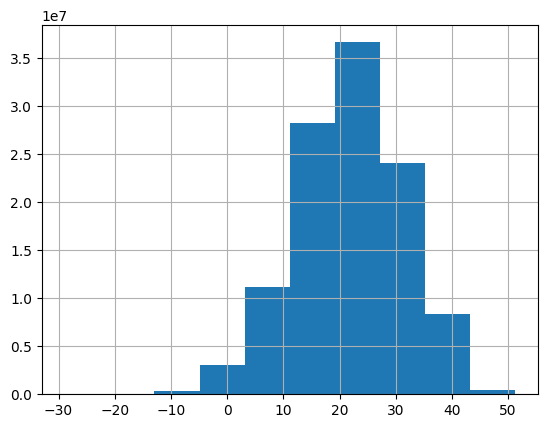

In [13]:
df.MEAN_NONE_SPATIAL_NEIGHBORS.hist()

In [14]:
df = df.rename(
    columns={
        "MEAN_NONE_SPATIAL_NEIGHBORS": "tmax",
    }
)

In [15]:
df.columns

Index(['time', 'locations', 'tmax', 'lat', 'lon', 'labelDim',
       'location_label'],
      dtype='object')

In [18]:
df = df.drop(columns=["lat","lon","locations","labelDim"])

In [19]:
df.head()

,time,tmax,location_label
0,2004-12-31,10.507685,04001942600
1,2004-12-31,10.008235,04001942700
2,2004-12-31,8.527029,04001944000
3,2004-12-31,8.570941,04001944100
4,2004-12-31,9.604968,04001944201


In [20]:
df.to_parquet("outputs/temp_merge_1.parquet")

In [26]:
# tmax["MEAN_NONE_SPATIAL_NEIGHBORS"].plot()

In [27]:
# tmin = xr.open_dataset("data/esri/MinTemp_2006_2021_Cali.nc")

In [28]:
# rhum = xr.open_dataset("data/esri/RelHum_2006_2021_Cali.nc")

## Join tmax, tmin and rhum

In [29]:
# df = xr.merge([tmax, tmin[["MIN_TEMPERATURE_NONE_SPATIAL_NEIGHBORS"]]])

In [30]:
# df = xr.merge([df, rhum[["RELATIVE_HUMIDITY_NONE_SPATIAL_NEIGHBORS"]]])

In [31]:
# del tmin
# del tmax
# del rhum

In [32]:
# df = df[
#     [
#         "FIPS",
#         "MAX_TEMPERATURE_NONE_SPATIAL_NEIGHBORS",
#         "MIN_TEMPERATURE_NONE_SPATIAL_NEIGHBORS",
#         "RELATIVE_HUMIDITY_NONE_SPATIAL_NEIGHBORS",
#     ]
# ].to_dataframe()

# df = df.rename(
#     columns={
#         "MAX_TEMPERATURE_NONE_SPATIAL_NEIGHBORS": "tmax",
#         "MIN_TEMPERATURE_NONE_SPATIAL_NEIGHBORS": "tmin",
#         "RELATIVE_HUMIDITY_NONE_SPATIAL_NEIGHBORS": "rhum",
#     }
# )

In [8]:
wf = xr.open_dataset("data/wc/Wildfireday_daily_CensusTract_2006_2021_WesternUS.nc")

In [9]:
locs = wf[["location_label"]].to_dataframe()

In [10]:
wf = wf[["FIREDAY_NONE_ZEROS"]].to_dataframe()

In [11]:
wf.FIREDAY_NONE_ZEROS.value_counts(dropna=False)

FIREDAY_NONE_ZEROS
0.0    105698359
1.0       124793
Name: count, dtype: int64

In [18]:
wf.locations.nunique()

18108

In [13]:
wf = wf.reset_index()
locs = locs.reset_index()

In [25]:
df = wf.merge(locs, left_on='locations', right_on="labelDim", how='left')

In [27]:
df = df.drop(columns=["lat","lon","locations","labelDim"])

In [29]:
df = df.rename(
    columns={
        "FIREDAY_NONE_ZEROS": "wfday",
    }
)

In [35]:
df.head()

wfday
time       location_label       
2005-12-31 04001942600       0.0
           04001942700       0.0
           04001944000       0.0
           04001944100       0.0
           04001944201       0.0

In [32]:
len(df)

105823152

In [33]:
df = df.groupby(by=["time", "location_label"]).first()

In [34]:
len(df)

105823152

In [36]:
df.to_parquet("outputs/temp_merge_2.parquet")

In [45]:
df2 = pd.read_parquet("outputs/temp_merge_1.parquet")

In [46]:
df = pd.read_parquet("outputs/temp_merge_2.parquet")

In [38]:
len(df2)

112432572

In [47]:
df2 = df2.groupby(by=["time", "location_label"]).first()

In [48]:
df = df.join(df2)

In [17]:
# df = xr.merge([tmax, wf[["FIREDAY_NONE_ZEROS"]]])
# df = df[
#     [
#         "FIPS",
#         "MEAN_NONE_SPATIAL_NEIGHBORS",
#         "FIREDAY_NONE_ZEROS",
#     ]
# ].to_dataframe()

# df = df.rename(
#     columns={
#         "MEAN_NONE_SPATIAL_NEIGHBORS": "tmax",
#         "FIREDAY_NONE_ZEROS": "wfday",
#     }
# )

In [49]:
df.to_parquet("outputs/temp_merge_3.parquet")

In [50]:
df.head()

wfday       tmax
time       location_label                  
2005-12-31 04001942600       0.0  12.056090
           04001942700       0.0  11.032996
           04001944000       0.0   9.850354
           04001944100       0.0   9.774376
           04001944201       0.0  11.232711

In [51]:
df = df.loc[(slice(pd.Timestamp("2006-01-01"), None), slice(None)), :]

In [52]:
df = df.loc[(slice(None, pd.Timestamp("2020-12-31")), slice(None)), :]

In [53]:
df.to_parquet("outputs/temp_merge_4.parquet")

In [ ]:
df = pd.read_parquet("outputs/temp_merge_4.parquet", engine="pyarrow")

In [4]:
df.head()

wfday       tmax
time       location_label                  
2006-01-01 04001942600       0.0  15.978498
           04001942700       0.0  14.836937
           04001944000       0.0  14.192923
           04001944100       0.0  14.254541
           04001944201       0.0  15.200634

In [24]:
#df = df.groupby(by=["time", "lat", "lon"]).first()

In [54]:
df.head()

wfday       tmax
time       location_label                  
2006-01-01 04001942600       0.0  15.978498
           04001942700       0.0  14.836937
           04001944000       0.0  14.192923
           04001944100       0.0  14.254541
           04001944201       0.0  15.200634

In [55]:
df.isna().sum()

wfday    0
tmax     0
dtype: int64

## Add PM 2.5

In [28]:
# pm25 = xr.open_dataset("data/esri/PM25_Nature_2006_2020_Cali.nc")
# df_pm25 = pm25[["MEAN_NONE_SPATIAL_NEIGHBORS"]].to_dataframe()
# df_pm25 = df_pm25.rename(columns={"MEAN_NONE_SPATIAL_NEIGHBORS": "pm25"})
# df_pm25 = df_pm25.reset_index()
# df_pm25 = df_pm25.groupby(by=["time", "lat", "lon"]).first()
# df_pm25.head()
# df.head()
# df = df.join(df_pm25, rsuffix="_pm25").progress_apply(lambda x: x)
# df.to_parquet("outputs/temp_merge_3.parquet")
# df.isna().sum()
# df.head()
# len(df.FIPS.unique())
# df = df.reset_index()

## Add crosswalk

In [1]:
import geopandas as gpd
gdf = gpd.read_file("data/WesternUSCensusTract/CensusTract2020_WesternUS.shp")
gdf.head()
# df.FIPS = df.FIPS.astype(int)
# gdf = gdf.drop(columns=["Shape_Leng", "Shape_Area"])
# df.FIPS.value_counts()
# df = df.merge(gdf, on="FIPS")
# len(df)
# df.isna().sum()
# type(df)
# df = df.drop(columns="geometry")
# df.to_parquet("outputs/temp_merge_4.parquet")

,STATE_ABBR,STATE_FIPS,COUNTY_FIP,STCOFIPS,TRACT_FIPS,FIPS,POPULATION,POP_SQMI,SQMI,Shape_Leng,Shape_Area,geometry
0,AZ,04,001,04001,942600,04001942600,1549,2.6,589.09,232812.475761,1.525731e+09,"POLYGON ((-1218270.401 32832.246, -1211358.143..."
1,AZ,04,001,04001,942700,04001942700,4491,3.9,1155.35,494105.485641,2.992333e+09,"POLYGON ((-1152995.229 23611.170, -1151650.010..."
2,AZ,04,001,04001,944000,04001944000,5348,17.5,305.81,189340.223564,7.920447e+08,"POLYGON ((-1163367.996 -71037.222, -1163356.94..."
3,AZ,04,001,04001,944100,04001944100,5495,7.8,708.25,396654.409548,1.834355e+09,"POLYGON ((-1174876.260 -9365.197, -1174863.596..."
4,AZ,04,001,04001,944201,04001944201,4021,20.7,193.93,116350.697095,5.022734e+08,"POLYGON ((-1210854.946 -45587.815, -1210757.05..."


In [3]:
gdf["STATE_ABBR"].unique()

array(['AZ', 'CA', 'CO', 'ID', 'MT', 'NV', 'NM', 'OR', 'TX', 'UT', 'WA',
       'WY'], dtype=object)

In [4]:
gdf["FIPS"].nunique()

18108

## Join smoke PM2.5

In [ ]:
# smoke_df = pd.read_parquet("outputs/smoke_pm25_predicted_with_fips.parquet")

In [3]:
smoke_df = pd.read_parquet(
    "data/smoke_pm/smoke_pm_all_time_2020_map.parquet")

In [4]:
smoke_df.head()

,FIPS,smoke_pm,date
0,04001942600,0.0,2006-01-01
1,04001942700,0.0,2006-01-01
2,04001944000,0.0,2006-01-01
3,04001944100,0.0,2006-01-01
4,04001944201,0.0,2006-01-01


In [5]:
len(smoke_df.FIPS.unique())

18108

In [6]:
smoke_df = smoke_df.rename(columns={"FIPS":"location_label"})

In [7]:
smoke_df = smoke_df.rename(columns={"date":"time"})

In [8]:
smoke_df = smoke_df.groupby(by=["time", "location_label"]).first()

In [9]:
smoke_df.head()

smoke_pm
time       location_label          
2006-01-01 04001942600          0.0
           04001942700          0.0
           04001944000          0.0
           04001944100          0.0
           04001944201          0.0

In [ ]:
df.head()

In [19]:
merged = df.join(smoke_df)

In [ ]:
# df["FIPS_1"] = df["FIPS_1"].astype(int)

In [ ]:
# merged = df.merge(smoke_df, left_on=["FIPS_1", "time"], right_on=["GEOID", "date"])

In [20]:
merged.head()

wfday       tmax  smoke_pm
time       location_label                            
2006-01-01 04001942600       0.0  15.978498       0.0
           04001942700       0.0  14.836937       0.0
           04001944000       0.0  14.192923       0.0
           04001944100       0.0  14.254541       0.0
           04001944201       0.0  15.200634       0.0

In [23]:
len(smoke_df)

97946172

In [21]:
len(merged)

99213732

In [ ]:
# merged = merged.drop(
#     columns=["lat", "lon", "locations", "FIPS", "locations_pm25", "date"]
# )

In [27]:
merged.head()

wfday       tmax  smoke_pm
time       location_label                            
2006-01-01 04001942600       0.0  15.978498       0.0
           04001942700       0.0  14.836937       0.0
           04001944000       0.0  14.192923       0.0
           04001944100       0.0  14.254541       0.0
           04001944201       0.0  15.200634       0.0

In [24]:
merged.to_parquet("outputs/final_merge_5_western_us.parquet")